In [1]:
import os

# imports

In [2]:
import classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import shutil
import os
import time
import copy
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import random
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import pandas as pd
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve, precision_score, recall_score, accuracy_score
import seaborn as sns

cuda


# General

In [3]:
PROJECT_PATH = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# specifics

In [4]:
torch.manual_seed(42)
batch_size = 8
h_dim = 800
z_dim = 35
x_sigma2 = 0.0015
learn_rate = 0.0002
betas = (0.99, 0.999)
train_mode ='finetune'
num_epochs = 2
class_certainty_threshold = 0.95  
sub_class_certainty_threshold = 0.75
momentum = 0.9
step_size =  7
gamma = 0.1
model_name = 'resnet18'
retrain = False
load_model = os.path.join(PROJECT_PATH, "resnet18.pth")

#after adding classes
learning_rate_first_layers = 0.001
learning_rate_final_layer = 0.01
eveluate = False

# datasets and loaders

## prepare labels

In [5]:
DATA_DIR_PATH = os.path.join(PROJECT_PATH, 'dataset')

## datasets

In [6]:
# Define data transformations including data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create the custom dataset
dataset = classifier.CustomDataset(DATA_DIR_PATH, transform=transform)

# Split the dataset into train, validation, and test subsets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
ds = {'train': train_data, 'valid': val_data, 'test': test_data}

## data loaders

In [8]:
# Create data loaders for each split
dataloaders = {key: DataLoader(ds[key], batch_size=batch_size, shuffle=True) for key in ds.keys()} 
dataset_sizes = {
    'train': len(train_data),
    'valid': len(val_data)
}

# Model

## chose model

In [9]:
model_name

'resnet18'

In [10]:
model_ft = classifier.create_model_instance(model_name, len(dataset.main_classes_set.keys())) 

# Transfer the model to GPU
model_ft = model_ft.to(device)

Creating resnet18


/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## params

In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer_ft = optim.AdamW(model_ft.parameters(), betas=betas)
# Learning rate decay
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

# Train

## fit/train

In [12]:
# Model training routine 
if retrain:
    # Train the model
    model_ft = classifier.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       dataloaders, dataset_sizes, device, num_epochs=num_epochs)
else:
    # Load weights
    checkpoint = torch.load(load_model)
    model_name = checkpoint['model_name']
    num_classes = checkpoint['num_classes']
    model_state_dict = checkpoint['state_dict']
    class_labels = checkpoint['class_labels']
    model_ft.load_state_dict(torch.load(model_name+'best_weights.pth'))

## save weights

In [13]:
# classifier.save_model(model_ft, model_name, num_classes, class_labels)
# classifier.save_layers_except_last(model_ft, model_name, num_classes, class_labels)

# Evaluation

In [14]:
if eveluate:
    classifier.evaluate_model_with_limited_misclassified(model_ft, dataloaders['test'], criterion, device, list(dataset.get_classes_names().values()))

# Pred specific image

In [15]:
image_path = os.path.join(PROJECT_PATH, 'dataset3', 'Sunflower', 'Sunflower_Downy_mildew', 'downymildew(2).jpeg')

In [16]:
classifier.predict_single_image(model_ft, image_path, device, dataset.get_classes_names())

Predicted Label: Arabica_coffee_Miner, Certainty: 0.35248225927352905


('Arabica_coffee_Miner', 0.35248225927352905)

# Continual Learning - Add new classes

## prepare new datasets and dataloaders

In [18]:
new_data_dir = os.path.join(PROJECT_PATH, 'dataset3')

classifier.add_new_classes_to_pretrained_model(dataset, model_ft, new_data_dir, criterion, transform,
                                               scheduler=exp_lr_scheduler,
                                                learning_rate_first_layers=learning_rate_first_layers,
                                                learning_rate_final_layer=learning_rate_final_layer,
                                                num_epochs=num_epochs)


TypeError: add_new_classes_to_pretrained_model() got an unexpected keyword argument 'optimizer'

## new model

In [ ]:
new_model = copy.deepcopy(model_ft)
new_model = classifier.modify_num_of_classes(new_model, num_new_classes, model_ft)

new_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
first_layers_params = []
final_layer_params = []

for name, param in new_model.named_parameters():
    if 'fc' not in name:
        first_layers_params.append(param)
    else:
        final_layer_params.append(param)
      
# Create separate parameter groups with different learning rates
param_groups = [
    {'params': first_layers_params, 'lr': 0},
    {'params': final_layer_params, 'lr': learning_rate_final_layer}
]

add_class_optimizer = optim.AdamW(param_groups, lr=0.001, weight_decay=0.01)

Epoch 0/1
----------


  0%|          | 0/654 [00:00<?, ?it/s]

/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 654/654 [02:30<00:00,  4.35it/s]


train Loss: 2.6107 Acc: 0.4929


100%|██████████| 141/141 [00:29<00:00,  4.81it/s]


valid Loss: 2.1274 Acc: 0.6102

Epoch 1/1
----------


100%|██████████| 654/654 [02:27<00:00,  4.43it/s]


train Loss: 2.3740 Acc: 0.5965


100%|██████████| 141/141 [00:27<00:00,  5.06it/s]


valid Loss: 2.5454 Acc: 0.6280

Training complete in 5m 55s
Best val Acc: 0.628011


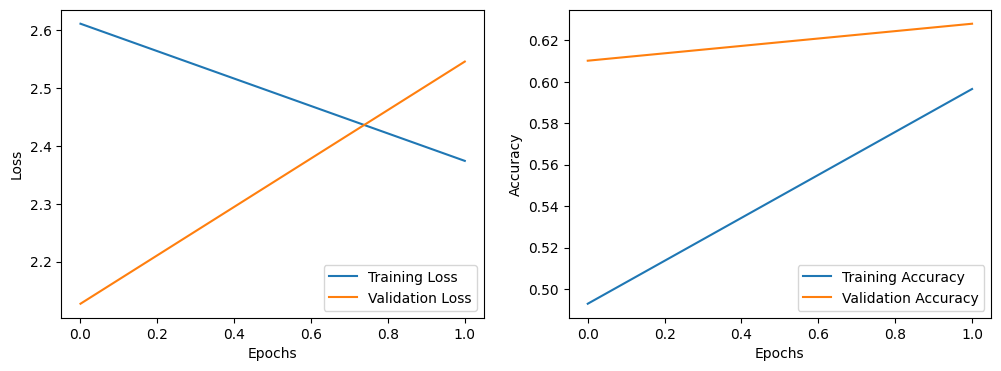

In [ ]:
own_concat_dataset_model = classifier.train_model(new_model, criterion, add_class_optimizer, exp_lr_scheduler, own_concat_class_dls, own_concat_class_dataset_sizes, device, num_epochs=num_epochs)

Evaluation Progress: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]
/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Loss: 2.4985
Evaluation Accuracy: 62.30


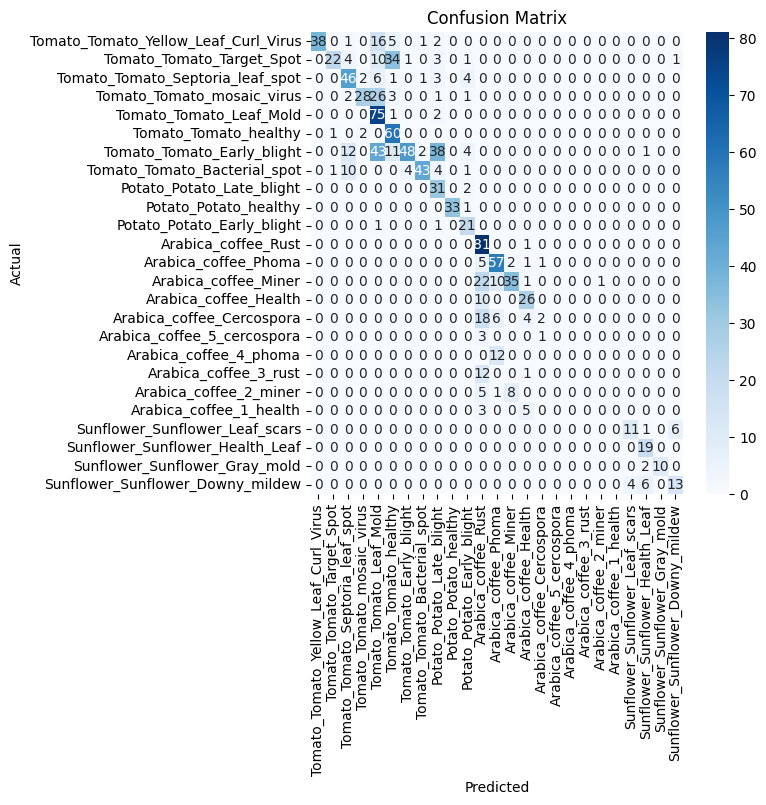

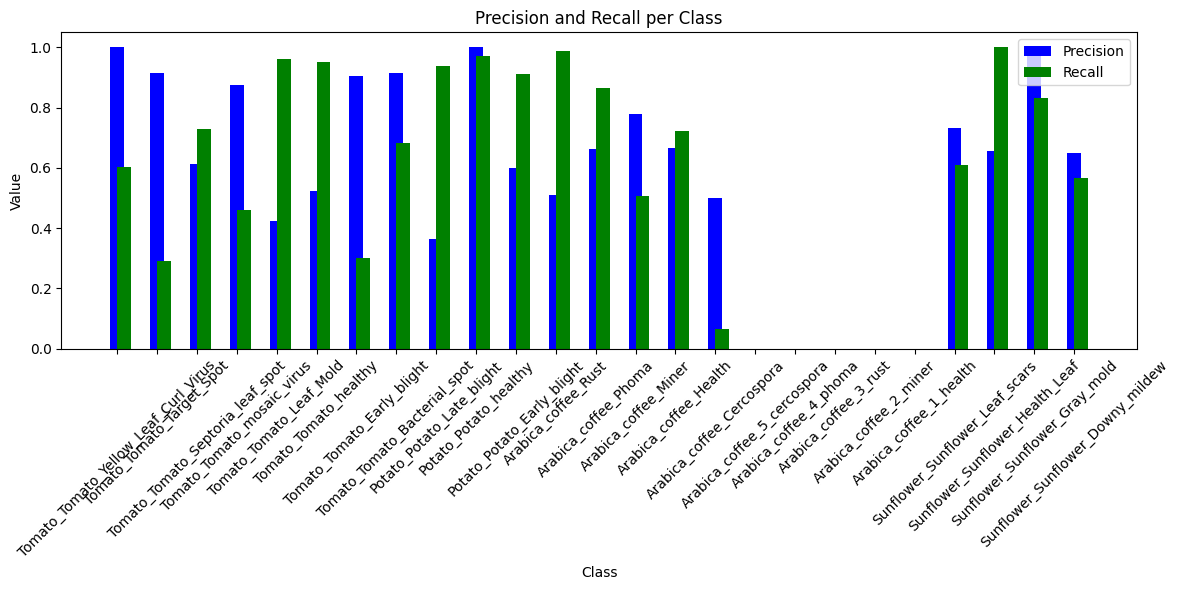

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                                   Class  Precision    Recall
0   Tomato_Tomato_Yellow_Leaf_Curl_Virus   1.000000  0.603175
1              Tomato_Tomato_Target_Spot   0.916667  0.289474
2       Tomato_Tomato_Septoria_leaf_spot   0.613333  0.730159
3             Tomato_Tomato_mosaic_virus   0.875000  0.459016
4                Tomato_Tomato_Leaf_Mold   0.423729  0.961538
5                  Tomato_Tomato_healthy   0.521739  0.952381
6             Tomato_Tomato_Early_blight   0.905660  0.301887
7           Tomato_Tomato_Bacterial_spot   0.914894  0.682540
8              Potato_Potato_Late_blight   0.364706  0.939394
9                  Potato_Potato_healthy   1.000000  0.970588
10            Potato_Potato_Early_blight   0.600000  0.913043
11                   Arabica_coffee_Rust   0.509434  0.987805
12                  Arabica_coffee_Phoma   0.662791  0.863636
13                  Arabica_coffee_Miner   0.777778  0.507246
14                 Arabica_coffee_Health   0.666667  0.722222
15      

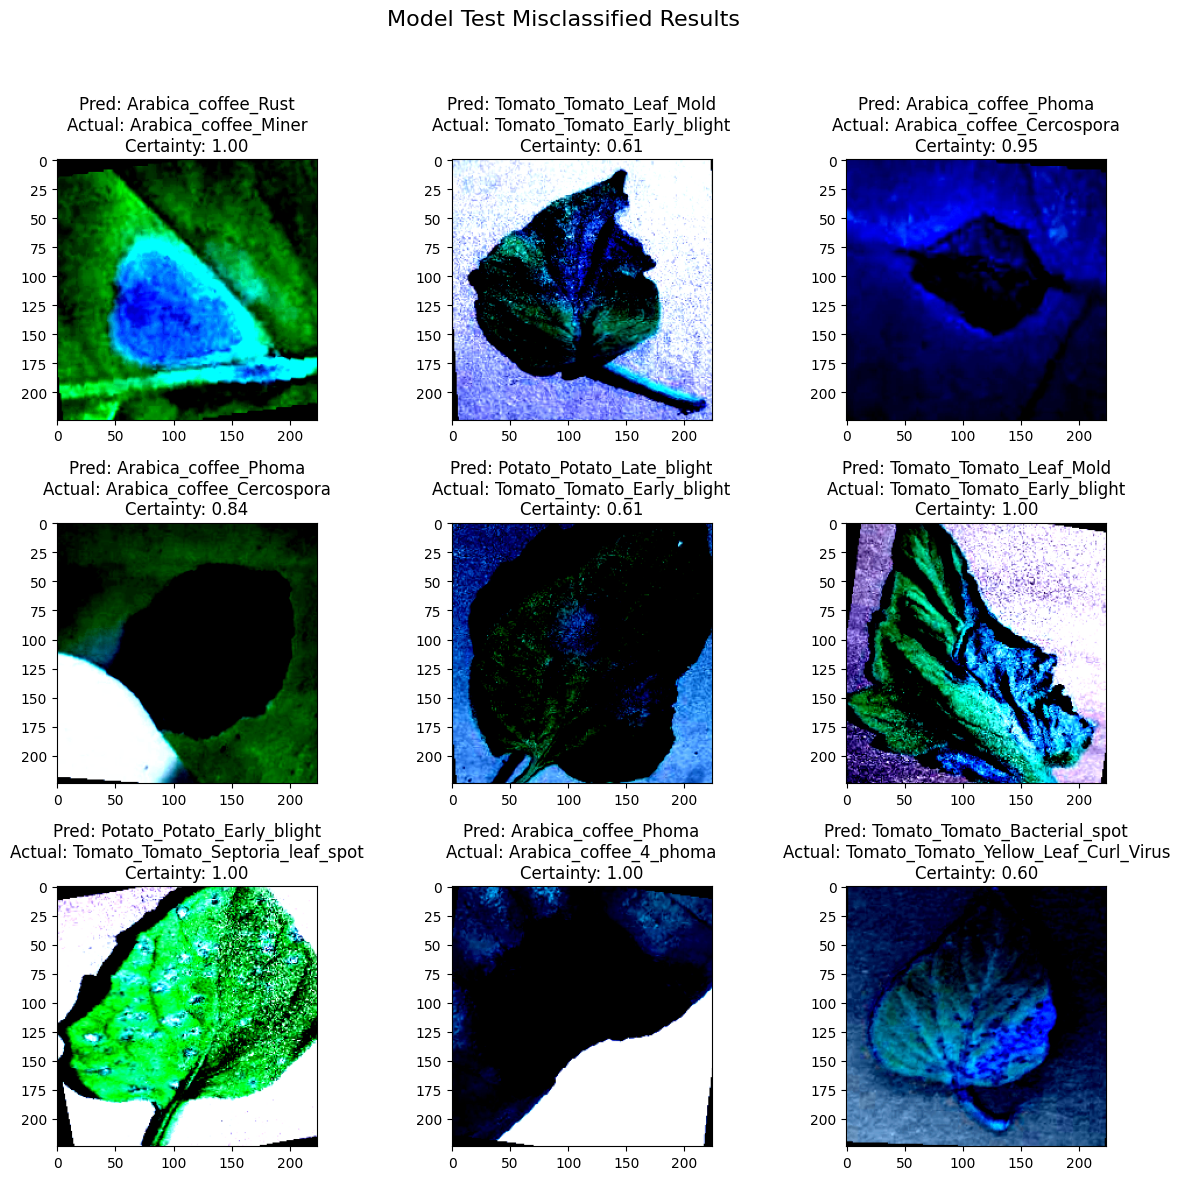

In [ ]:
if eveluate:
    classifier.evaluate_model_with_limited_misclassified(own_concat_dataset_model, own_concat_class_dls['test'], criterion, device, list(own_concat_dataset.get_classes_names().values()))
# eveluate_model_with_plots(own_concat_dataset_model, DataLoader(own_concat_dataset_ds['test'], batch_size=batch_size, shuffle=True), criterion, device, own_concat_dataset.get_classes_names().values())